In [166]:
import geopandas as gpd
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from adjustText import adjust_text
from scipy.stats import kendalltau, pearsonr

In [120]:
country = "Chile"
year = 2021
location_level = "province"

colors = json.load(open("consts.json", encoding="utf-8"))

In [121]:
regions = {
    "DE ARICA Y PARINACOTA": "Región de Arica y Parinacota",
    "DE TARAPACA": "Región de Tarapacá",
    "DE ANTOFAGASTA": "Región de Antofagasta",
    "DE ATACAMA": "Región de Atacama",
    "DE COQUIMBO": "Región de Coquimbo",
    "DE VALPARAISO": "Región de Valparaíso",
    "METROPOLITANA DE SANTIAGO": "Región Metropolitana de Santiago",
    "DEL LIBERTADOR GENERAL BERNARDO O'HIGGINS": "Región del Libertador Bernardo O'Higgins",
    "DEL MAULE": "Región del Maule",
    "DE ÑUBLE": "Región de Ñuble",
    "DEL BIOBIO": "Región del Bío-Bío",
    "DE LA ARAUCANIA": "Región de La Araucanía",
    "DE LOS RIOS": "Región de Los Ríos",
    "DE LOS LAGOS": "Región de Los Lagos",
    "DE AYSEN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO": "Región de Aysén del Gral.Ibañez del Campo",
    "DE MAGALLANES Y DE LA ANTARTICA CHILENA": "Región de Magallanes y Antártica Chilena"
}

In [122]:
gdf = gpd.read_file("geo_shapes/Chile_provinces.zip")
gdf["Provincia"] = gdf["Provincia"].str.upper().str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
gdf = gdf.rename(columns={"Provincia": "province"})
gdf.head()

,objectid,cir_sena,codregion,cod_prov,st_area_sh,st_length_,province,Region,geometry
0,402,3,2,21,8.182788e+10,1.943356e+06,ANTOFAGASTA,Región de Antofagasta,"MULTIPOLYGON (((-7870470.961 -2985679.186, -78..."
1,403,1,15,151,9.780923e+09,5.802460e+05,ARICA,Región de Arica y Parinacota,"POLYGON ((-7748273.366 -2108728.860, -7747986...."
2,404,4,3,32,3.092682e+10,1.140780e+06,CHANARAL,Región de Atacama,"MULTIPOLYGON (((-7868800.549 -3017643.396, -78..."
3,405,4,3,31,4.174742e+10,1.528341e+06,COPIAPO,Región de Atacama,"MULTIPOLYGON (((-7932747.769 -3311218.615, -79..."
4,406,3,2,22,4.976879e+10,1.177398e+06,EL LOA,Región de Antofagasta,"POLYGON ((-7615643.575 -2384075.436, -7615022...."


In [123]:
# gdf = gpd.read_file("https://raw.githubusercontent.com/fcortes/Chile-GeoJSON/master/comunas.geojson")
# gdf.head()
# gdf["Comuna"] = gdf["Comuna"].str.upper().str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
# gdf = gdf.rename(columns={"Comuna": "commune"})

In [124]:
df = pd.read_csv(f"data_output/{country}/{year}_divisiveness_{location_level}.csv.gz", compression="gzip")

if location_level == "province":
    df["province"] = df["province"].replace({
        "BIOBIO": "BIO-BIO",
        "CHAÑARAL": "CHANARAL",
        "DEL TAMARUGAL": "TAMARUGAL",
        "SAN FELIPE DE ACONCAGUA": "SAN FELIPE"
    })
df.head()

,province,candidate,value
0,ANTARTICA CHILENA,FRANCO PARISI FERNANDEZ,0.690066
1,ANTARTICA CHILENA,GABRIEL BORIC FONT,0.000000
2,ANTARTICA CHILENA,JOSE ANTONIO KAST RIST,0.000000
3,ANTARTICA CHILENA,MARCO ENRIQUEZ-OMINAMI GUMUCIO,0.951190
4,ANTARTICA CHILENA,SEBASTIAN SICHEL RAMIREZ,0.975900


In [125]:
set(df_fround[location_level].unique()) - set(gdf[location_level].unique())

set()

In [126]:
set(gdf[location_level].unique()) - set(df_fround[location_level].unique())

{'ZONA SIN DEMARCAR'}

In [169]:
pd.read_csv(f"data_output/{country}/{year}_first_round.csv.gz", compression="gzip")

,polling_id,candidate,value,rank,rate
0,ALTO HOSPICIO-ALTO HOSPICIO-ANEXO DE COLEGIO S...,GABRIEL BORIC FONT,22.0,3,0.134969
1,ALTO HOSPICIO-ALTO HOSPICIO-ANEXO DE COLEGIO S...,JOSE ANTONIO KAST RIST,36.0,2,0.220859
2,ALTO HOSPICIO-ALTO HOSPICIO-ANEXO DE COLEGIO S...,YASNA PROVOSTE CAMPILLAY,15.0,5,0.092025
3,ALTO HOSPICIO-ALTO HOSPICIO-ANEXO DE COLEGIO S...,SEBASTIAN SICHEL RAMIREZ,12.0,6,0.073620
4,ALTO HOSPICIO-ALTO HOSPICIO-ANEXO DE COLEGIO S...,EDUARDO ARTES BRICHETTI,1.0,7,0.006135
...,...,...,...,...,...
326468,YUNGAY-YUNGAY-LICEO DE YUNGAY-21-M-21M,YASNA PROVOSTE CAMPILLAY,20.0,5,0.112360
326469,YUNGAY-YUNGAY-LICEO DE YUNGAY-21-M-21M,SEBASTIAN SICHEL RAMIREZ,30.0,3,0.168539
326470,YUNGAY-YUNGAY-LICEO DE YUNGAY-21-M-21M,EDUARDO ARTES BRICHETTI,1.0,7,0.005618
326471,YUNGAY-YUNGAY-LICEO DE YUNGAY-21-M-21M,MARCO ENRIQUEZ-OMINAMI GUMUCIO,10.0,6,0.056180


In [127]:
df_fround = pd.read_csv(f"data_output/{country}/{year}_first_round.csv.gz", compression="gzip")
df_fround.columns = [x.lower() for x in df_fround.columns]

df_runoff = pd.read_csv(f"data_output/{country}/{year}_runoff.csv.gz", compression="gzip")
df_runoff.columns = [x.lower() for x in df_runoff.columns]

candidate_a, candidate_b = df_runoff.candidate.unique()
df_location = pd.read_csv(f"data_output/{country}/{year}_first_round_location.csv.gz", compression="gzip")

df_fround = pd.merge(df_fround, df_location, on="polling_id")
df_runoff = pd.merge(df_runoff, df_location, on="polling_id")

if location_level == "province":
    df_fround["province"] = df_fround["province"].replace({
        "BIOBIO": "BIO-BIO",
        "CHAÑARAL": "CHANARAL",
        "DEL TAMARUGAL": "TAMARUGAL",
        "SAN FELIPE DE ACONCAGUA": "SAN FELIPE"
    })
    
    df_runoff["province"] = df_runoff["province"].replace({
        "BIOBIO": "BIO-BIO",
        "CHAÑARAL": "CHANARAL",
        "DEL TAMARUGAL": "TAMARUGAL",
        "SAN FELIPE DE ACONCAGUA": "SAN FELIPE"
    })

In [128]:
data = pd.merge(gdf, df, on=location_level)
data.head()

,objectid,cir_sena,codregion,cod_prov,st_area_sh,st_length_,province,Region,geometry,candidate,value
0,402,3,2,21,8.182788e+10,1.943356e+06,ANTOFAGASTA,Región de Antofagasta,"MULTIPOLYGON (((-7870470.961 -2985679.186, -78...",FRANCO PARISI FERNANDEZ,0.916126
1,402,3,2,21,8.182788e+10,1.943356e+06,ANTOFAGASTA,Región de Antofagasta,"MULTIPOLYGON (((-7870470.961 -2985679.186, -78...",GABRIEL BORIC FONT,0.706282
2,402,3,2,21,8.182788e+10,1.943356e+06,ANTOFAGASTA,Región de Antofagasta,"MULTIPOLYGON (((-7870470.961 -2985679.186, -78...",JOSE ANTONIO KAST RIST,0.842770
3,402,3,2,21,8.182788e+10,1.943356e+06,ANTOFAGASTA,Región de Antofagasta,"MULTIPOLYGON (((-7870470.961 -2985679.186, -78...",MARCO ENRIQUEZ-OMINAMI GUMUCIO,0.863479
4,402,3,2,21,8.182788e+10,1.943356e+06,ANTOFAGASTA,Región de Antofagasta,"MULTIPOLYGON (((-7870470.961 -2985679.186, -78...",SEBASTIAN SICHEL RAMIREZ,0.900464


(-9079087.499644011,
 -7313382.482540761,
 -7833211.379485001,
 -1700143.9536150019)

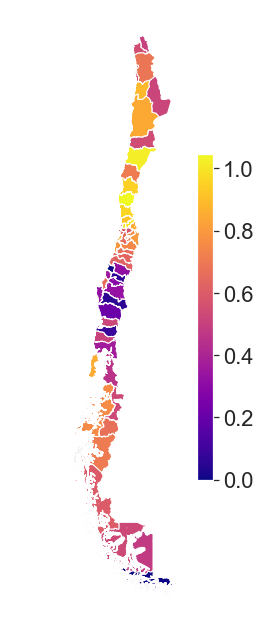

In [129]:
fig, ax = plt.subplots(figsize=(4, 20))

data_tmp = data[data["candidate"] == "JOSE ANTONIO KAST RIST"]
data_tmp = data_tmp[~data_tmp["province"].isin(["ISLA DE PASCUA", "JUAN FERNANDEZ"])]
data_tmp.plot(
    column="value", cmap="plasma", ax=ax, legend=True,
             legend_kwds=dict(
     shrink=0.3
    ))

plt.axis("off")

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(-9079087.499644011,
 -7313382.482540761,
 -7833211.379485001,
 -1700143.9536150019)

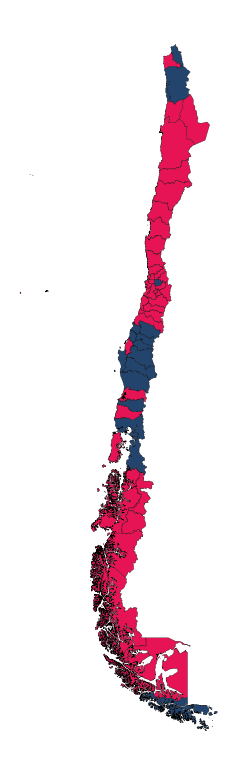

In [130]:
# df_fround["rank"] = df_fround.groupby([location_level, "candidate"]).agg({"value": "sum"}).groupby(level=0)["value"].rank(ascending=False).astype(int)
#df_fround.groupby(location_level)["value"].rank(ascending=False).astype(int)

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
dd = df_runoff.groupby([location_level, "candidate"]).agg({"value": "sum"})
dd["rank"] = dd.groupby(level=0)["value"].rank(ascending=False).astype(int)
dd = dd.reset_index()

data_tmp = dd[dd["rank"] == 1]
data_tmp = pd.merge(data_tmp, gdf, on=location_level)
data_tmp = data_tmp[~data_tmp["province"].isin(["ISLA DE PASCUA", "JUAN FERNANDEZ"])]
data_tmp["color"] = data_tmp["candidate"].replace(colors)

data_tmp = gpd.GeoDataFrame(data_tmp)
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data_tmp.plot(
    column="candidate",
    color=data_tmp["color"],
    edgecolor="black",
    lw=0.2,
    ax=ax, 
    legend=True, 
    legend_kwds=dict(
#         shrink=0.3
    )
)

plt.axis("off")

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(-9079087.499644011,
 -7313382.482540761,
 -7833211.379485001,
 -1700143.9536150019)

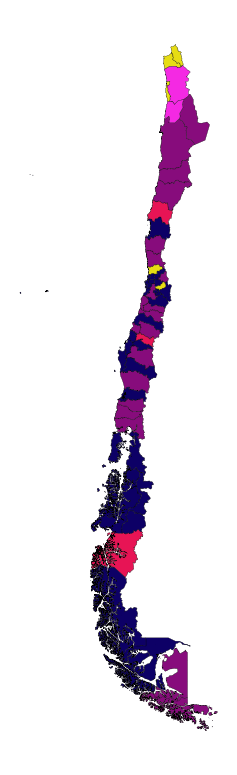

In [131]:
df["rank"] = df.groupby(location_level)["value"].rank(ascending=False).astype(int)

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

data_tmp = df[df["rank"] == 1]
data_tmp = pd.merge(data_tmp, gdf, on=location_level)
data_tmp = data_tmp[~data_tmp["province"].isin(["ISLA DE PASCUA", "JUAN FERNANDEZ"])]
data_tmp["color"] = data_tmp["candidate"].replace(colors)

data_tmp = gpd.GeoDataFrame(data_tmp)
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data_tmp.plot(
    column="candidate",
    color=data_tmp["color"],
    edgecolor="black",
    lw=0.2,
    ax=ax, 
    legend=True, 
    legend_kwds=dict(
#         shrink=0.3
    )
)

plt.axis("off")

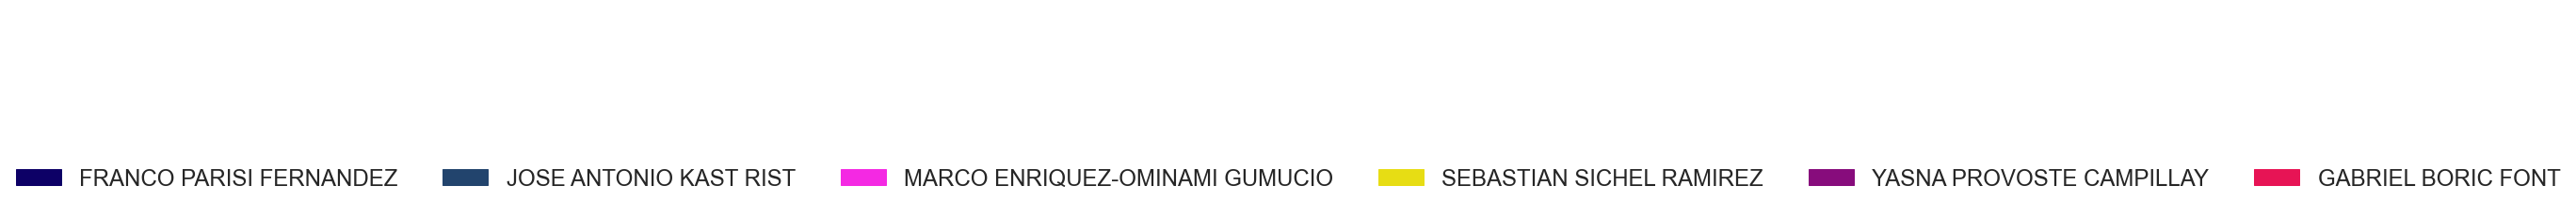

In [132]:
#Imports
import matplotlib.patches as mpatches

# where some data has already been plotted to ax
handles, labels = ax.get_legend_handles_labels()

for key in colors.keys():
    if key in df["candidate"].unique():
        value = colors[key]
        patch = mpatches.Patch(color=value, label=key)
        handles.append(patch) 
        
legend = plt.legend(handles=handles, loc='lower center', fontsize=24, frameon=False, ncol=len(handles))

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # fig.savefig(filename, dpi="figure", bbox_inches=bbox)

plt.axis("off")
# export_legend(legend)
# plt.show()
legend

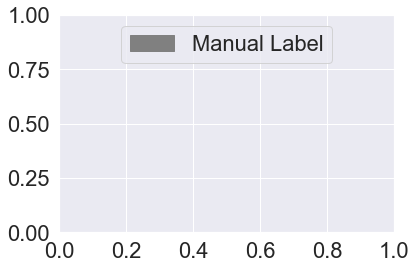

In [133]:


#Imports
import matplotlib.patches as mpatches

# where some data has already been plotted to ax
handles, labels = ax.get_legend_handles_labels()

# manually define a new patch 
patch = mpatches.Patch(color='grey', label='Manual Label')

# handles is a list, so append manual patch
handles.append(patch) 

# plot the legend
plt.legend(handles=handles, loc='upper center')

In [134]:
endorsements = {
    "JOSE ANTONIO KAST RIST": [("SEBASTIAN SICHEL RAMIREZ", "FRANCO PARISI FERNANDEZ"), ()],
    "GABRIEL BORIC FONT": [("MARCO ENRIQUEZ-OMINAMI GUMUCIO", "YASNA PROVOSTE CAMPILLAY"), ()]
}

aa = df_fround[df_fround["candidate"].isin(endorsements[candidate_a][0])].groupby("polling_id").agg({"rate": "sum"})
aa = aa.reset_index()
aa = aa.rename(columns={"rate": candidate_a})

bb = df_fround[df_fround["candidate"].isin(endorsements[candidate_b][0])].groupby("polling_id").agg({"rate": "sum"})
bb = bb.reset_index()
bb = bb.rename(columns={"rate": candidate_b})


df_endorsement = pd.merge(aa, bb, on="polling_id")
df_endorsement

,polling_id,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST
0,ALGARROBO-ALGARROBO-COLEGIO TERESA DE LOS ANDE...,0.166667,0.149425
1,ALGARROBO-ALGARROBO-COLEGIO TERESA DE LOS ANDE...,0.179894,0.227513
2,ALGARROBO-ALGARROBO-COLEGIO TERESA DE LOS ANDE...,0.148305,0.182203
3,ALGARROBO-ALGARROBO-COLEGIO TERESA DE LOS ANDE...,0.123404,0.229787
4,ALGARROBO-ALGARROBO-COLEGIO TERESA DE LOS ANDE...,0.148148,0.189300
...,...,...,...
46634,ÑUÑOA-PLAZA ÑUÑOA-LICEO REPUBLICA DE SIRIA-59-...,0.159184,0.232653
46635,ÑUÑOA-PLAZA ÑUÑOA-LICEO REPUBLICA DE SIRIA-60-...,0.154206,0.135514
46636,ÑUÑOA-PLAZA ÑUÑOA-LICEO REPUBLICA DE SIRIA-61-...,0.154812,0.192469
46637,ÑUÑOA-PLAZA ÑUÑOA-LICEO REPUBLICA DE SIRIA-62-...,0.132479,0.179487


In [135]:
aa = df_fround.groupby("polling_id").agg({"value": "sum"}).reset_index()
bb = df_runoff.groupby("polling_id").agg({"value": "sum"}).reset_index()
cc = df_location.groupby("polling_id").agg({"voters": "sum"}).reset_index()
aa = pd.merge(aa, cc, on="polling_id")
aa["participation"] = aa["value"] / aa["voters"]
bb = pd.merge(bb, cc, on="polling_id")
bb["participation"] = bb["value"] / bb["voters"]
cc = pd.merge(aa, bb, on="polling_id")
cc["diff_participation"] = cc["participation_y"] - cc["participation_x"]
cc["increase_participation"] = cc["diff_participation"] > 0
cc["increase_participation"] = cc["increase_participation"].astype(int)

In [136]:
cc.increase_participation.sum()
cc.shape

(46639, 9)

In [137]:
dd = pd.merge(df_fround, df_runoff, on=["polling_id", "candidate"])
dd = dd.pivot_table(index="polling_id", columns=["candidate"], values=["rate_x", "rate_y"])
dd = dd.reset_index()
dd.columns = [f"{a}{b}" for a, b in dd.columns]

dd["winner"] = dd.apply(lambda x: \
                        candidate_a if x[f"rate_x{candidate_a}"] > x[f"rate_x{candidate_b}"] else candidate_b, axis=1)
dd["loser"] = dd.apply(lambda x: \
                        candidate_a if x[f"rate_x{candidate_a}"] < x[f"rate_x{candidate_b}"] else candidate_b, axis=1)

dd["rate_winner"] = dd.apply(lambda x: \
                        x[f"rate_x{candidate_a}"] if x[f"rate_x{candidate_a}"] > x[f"rate_x{candidate_b}"] else x[f"rate_x{candidate_b}"], axis=1)
dd["rate_loser"] = dd.apply(lambda x: \
                        x[f"rate_x{candidate_a}"] if x[f"rate_x{candidate_a}"] < x[f"rate_x{candidate_b}"] else x[f"rate_x{candidate_b}"], axis=1)

dd = pd.merge(dd, df_location, on="polling_id")

dd = pd.merge(dd, df[["value", "candidate", location_level]].rename(columns={"value": "dv_winner"}), 
              left_on=[location_level, "winner"], right_on=[location_level, "candidate"])
dd = pd.merge(dd, df.rename(columns={"value": "dv_loser"}), 
    left_on=[location_level, "loser"], right_on=[location_level, "candidate"])
dd = pd.merge(dd, df_endorsement, on="polling_id")

dd["en_winner"] = dd.apply(lambda x: \
                        x[candidate_a] if x[f"rate_x{candidate_a}"] > x[f"rate_x{candidate_b}"] else x[candidate_b], axis=1)
dd["en_loser"] = dd.apply(lambda x: \
                        x[candidate_a] if x[f"rate_x{candidate_a}"] < x[f"rate_x{candidate_b}"] else x[candidate_b], axis=1)

dd["dv_diff"] = dd["dv_winner"] - dd["dv_loser"]
dd["rate_diff"] = dd["rate_winner"] - dd["rate_loser"]

dd["flip"] = ((dd[f"rate_x{candidate_a}"] > dd[f"rate_x{candidate_b}"]) & (dd[f"rate_y{candidate_a}"] < dd[f"rate_y{candidate_b}"])) |\
    ((dd[f"rate_x{candidate_b}"] > dd[f"rate_x{candidate_a}"]) & (dd[f"rate_y{candidate_b}"] < dd[f"rate_y{candidate_a}"]))

# dd = pd.merge(dd, ee, on=[location_level])
dd["flip"] = dd["flip"].astype(int)
dd = pd.merge(dd, cc[["polling_id", "diff_participation", "increase_participation"]], on="polling_id")
dd.to_csv("test2.csv", index=False)

In [138]:
dd.shape

(44927, 35)

In [140]:
# df_test = dd.copy()
# df_test["qdv_winner"] = pd.qcut(df_test["dv_winner"], 6).astype(str)
# df_test["qdv_loser"] = pd.qcut(df_test["dv_loser"], 6).astype(str)
# m = df_test.groupby(["qdv_winner", "qdv_loser"]).agg({"flip": "mean"}).reset_index()
# m = m.pivot(index="qdv_winner", columns="qdv_loser", values="flip")

# sns.set(font_scale=2)
# fig, ax = plt.subplots(figsize=(9.5, 8))
# g = sns.heatmap(m, cmap="plasma")
# g.invert_yaxis()
# g.set_xlabel("Divisiveness (%) Winner")
# g.set_ylabel("Divisiveness (%) Loser")
# g.set_xticklabels([])
# g.set_yticklabels([])
# g

In [141]:
# df_test = dd.copy().dropna()
# df_test["qdv_winner"] = pd.qcut(df_test["rate_winner"], 10).astype(str)
# df_test["qdv_loser"] = pd.qcut(df_test["rate_loser"], 10).astype(str)
# m = df_test.groupby(["qdv_winner", "qdv_loser"]).agg({"flip": "mean"}).reset_index()
# m = m.pivot(index="qdv_winner", columns="qdv_loser", values="flip")

# sns.set(font_scale=2)
# fig, ax = plt.subplots(figsize=(9.5, 8))
# g = sns.heatmap(m, cmap="plasma")
# g.invert_yaxis()
# g.set_xlabel("Rate (%) Winner")
# g.set_ylabel("Rate (%) Loser")
# g.set_xticklabels([])
# g.set_yticklabels([])
# g

In [152]:
values.values()

dict_values(['commune_id', 'commune', 'province_id', 'province', 'region_id', 'region'])

In [154]:
df_geo = pd.read_excel(
    "https://repositoriodeis.minsal.cl/ContenidoSitioWeb2020/uploads/2019/11/DPA2018.xls",
    header=1
)
values = {
    "Código Comuna desde 2018": "commune_id",
    "Nombre Comuna": "commune",
    "Código Provincia desde 2018": "province_id",
    "Provincia desde 2018": "province",
    "Código Región desde 2018": "region_id",
    "Nombre Región desde 2018": "region"
}
df_geo = df_geo.rename(columns=values)
df_geo = df_geo[values.values()]
df_geo.head()

,commune_id,commune,province_id,province,region_id,region
0,15101,Arica,151,Arica,15,De Arica y Parinacota
1,15102,Camarones,151,Arica,15,De Arica y Parinacota
2,15201,Putre,152,Parinacota,15,De Arica y Parinacota
3,15202,General Lagos,152,Parinacota,15,De Arica y Parinacota
4,1101,Iquique,11,Iquique,1,De Tarapacá


In [157]:
df_poverty = pd.read_excel("data_external/Chile/poverty_2020.xlsx", header=2)
df_poverty = df_poverty[~df_poverty["Nombre comuna"].isna()]
# df_poverty = df_poverty.rename(columns={"Nombre comuna": "commune", "Porcentaje de personas en situación de pobreza por ingresos 2020": "poverty_rate"})
# df_poverty["commune"] = df_poverty["commune"].apply(lambda x: x.upper())
df_poverty = df_poverty.rename(columns={
    "Nombre comuna": "commune", 
    "Código": "commune_id",
    "Número de personas según proyecciones de población (*)": "population",
    "Número de personas en situación de pobreza por ingresos (**)": "poverty",
    "Porcentaje de personas en situación de pobreza por ingresos 2020": "poverty_rate"
})

In [162]:
tmp = pd.merge(df_geo, df_poverty[["commune_id", "population", "poverty"]], on="commune_id")
tmp = tmp.groupby("province").agg({"population": "sum", "poverty": "sum"})
tmp["poverty_rate"] = tmp["poverty"] / tmp["population"]
tmp = tmp.reset_index()
tmp["province"] = tmp["province"].str.upper()
tmp.head()

,province,population,poverty,poverty_rate
0,AISÉN,32423.0,2331.803107,0.071918
1,ANTOFAGASTA,459105.0,39343.516067,0.085696
2,ANTÁRTICA CHILENA,1990.0,61.971569,0.031141
3,ARAUCO,176725.0,28530.569504,0.161440
4,ARICA,250056.0,29535.665508,0.118116


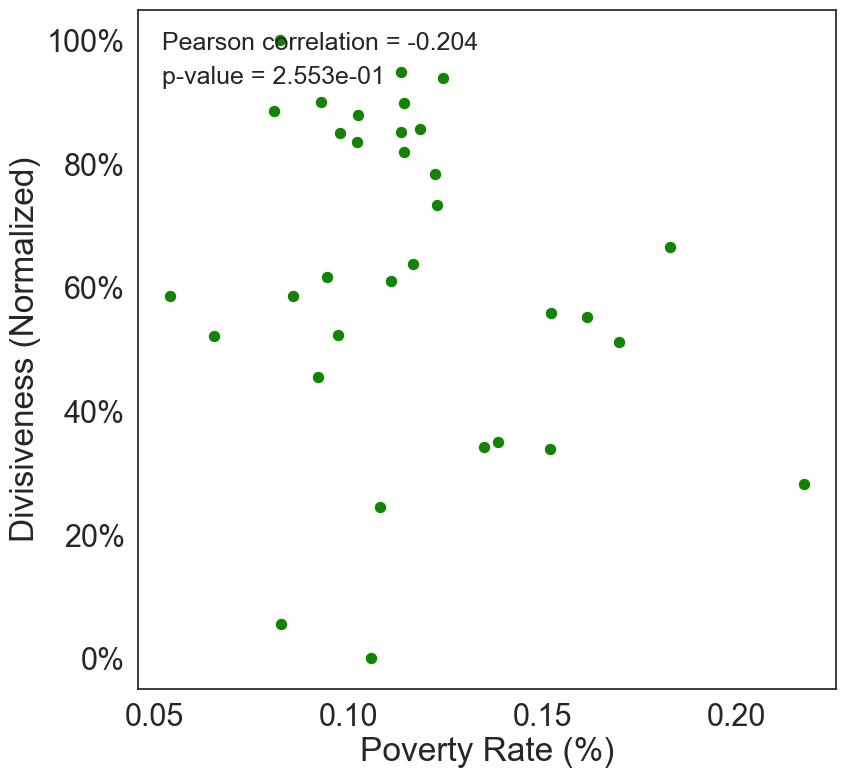

In [167]:
df_tmp = df.groupby("province").agg({"value": "mean"}).reset_index()
data = pd.merge(df_tmp, tmp, on="province")
# data = pd.merge(data, df_location[["province", "province_id"]].drop_duplicates(), on="department")
import numpy as np
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data["value"] = NormalizeData(data["value"])
sns.set(font_scale=2, style="white")
fig, ax = plt.subplots(figsize=(9, 9), dpi=100)

x = "poverty_rate"
y = "value"

corr, _ = pearsonr(data[x], data[y])
p_value = "{:0.3e}".format(_)

# plt.legend([], [], loc=2, title=f"R²={(corr*corr*100).round(1)}%\np-value={p_value}", frameon=False)
FONT_SIZE = 18
ax.text(
    0.035, 0.95, 
           f"Pearson correlation = {(corr).round(3)}", ha="left", va="center", fontsize=FONT_SIZE, 
           transform=ax.transAxes)
ax.text(0.035, 0.9, 
       f"p-value = {p_value}", ha="left", va="center", fontsize=FONT_SIZE, 
       transform=ax.transAxes)

sns.scatterplot(x="poverty_rate", s=80, lw=0, y="value", data=data, ax=ax, color="#138303")

ax.set_xlabel("Poverty Rate (%)")
ax.set_ylabel("Divisiveness (Normalized)")

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# texts = []
# for x, tmp in data.iterrows():
#     texts.append(ax.text(tmp["poverty_rate"], tmp["value"], tmp["department_id"], fontsize=16, color="#444444"))
    
# adjust_text(texts, lim=200, ax=ax, arrowprops=dict(arrowstyle="-", color="#766596")) 